## Sobre o trabalho

In [1]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils import Utils

## Sobre os dados

Link:

A base de dados utilizada no processo de trinamento do modelo possui ~{quantidade_img} imagens porém parte dela 
já tinha passado pelo processo de data augmentation e algumas técnicas, como por exemplo, transformação da imagem colorida para preto e branco, pensamos que não faria sentido em relação a nossa problemática, pois consideramos que que as imagens de entrada do modelo seriam sempre tiradas com alguma exposição à luz.
Por isso, descartamos as imagens das frutas que continham essas imagens.


Para realizar o teste final do modelo utilizamos uma das frutas, no caso, a maçã que está disponível em outro dataset (Link_dataset).


Quantidade de dados:

1. Treinamento:

   - fresca: 3817
   - podre: 4545
   
   
2. Validação:

   - fresca: 1325
   - podre: 1056
  
  
3. Teste:

    - fresca: 200
    - podre 200

Image shape: (256, 256, 3)


array([[[135, 130, 162],
        [126, 121, 153],
        [134, 129, 161],
        ...,
        [136, 132, 167],
        [160, 156, 189],
        [138, 134, 167]],

       [[140, 135, 167],
        [132, 127, 159],
        [137, 132, 164],
        ...,
        [113, 109, 144],
        [151, 147, 180],
        [150, 146, 179]],

       [[130, 125, 157],
        [126, 121, 153],
        [132, 127, 159],
        ...,
        [142, 138, 173],
        [172, 168, 201],
        [165, 161, 194]],

       ...,

       [[167, 164, 209],
        [172, 169, 214],
        [172, 169, 214],
        ...,
        [222, 224, 255],
        [222, 224, 255],
        [206, 208, 249]],

       [[184, 181, 226],
        [176, 173, 218],
        [161, 158, 203],
        ...,
        [202, 204, 245],
        [214, 216, 255],
        [214, 216, 255]],

       [[172, 169, 214],
        [158, 155, 200],
        [139, 136, 181],
        ...,
        [211, 212, 255],
        [209, 211, 252],
        [214, 216, 255]]

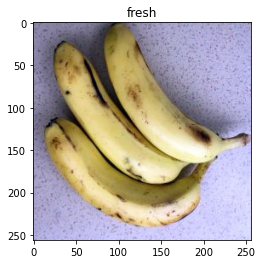

In [2]:
Utils.view_random_img(target_dir="data/train", target_class="fresh")

In [14]:
#Definição do caminho dos diretórios
train_dir = 'data/train/'
val_dir = 'data/validation/'

#Normalização das imagens, dividindo os valores dos pixels (0-255) por 255
#Passamos essa informação para Parametro rescale do ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)


#Carregamento das imagens e a divisão deles batches de tamanho 32, redimencionamento das imagens 
#para facilitar o treinamento para (224,224,3) e a própria biblioteca, devido a organização dos diretórios
#também consegue categorizar nossos dados. No nosso caso teremos duas categorias: Fresca ou Podre
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                              target_size=(224, 224),
                                              class_mode='binary', #Type of problem we are working with. Cuold be categorical
                                              batch_size=32)

val_data = val_datagen.flow_from_directory(directory=val_dir,
                                              target_size=(224, 224),
                                              class_mode='binary',
                                              batch_size=32)

#Pegando um lote de imagens/target no nosso dataset de treinamento
images, labels = train_data.next() 
print(f'{len(images)}, {len(labels)}')

#Pegando um lote de imagens/target no nosso dataset de validação
val_images, val_labels = val_data.next() 
print(f'{len(images)}, {len(labels)}')

#Visualizando a quantidade de lotes
print(f'Tamanho do lote: {len(train_data)}')

Found 8362 images belonging to 2 classes.
Found 2381 images belonging to 2 classes.
32, 32
32, 32
Tamanho do lote: 262


A célula acima foi utilizada para carregar as imagens, distribuir em lotes, realizar a normalização e redimencionamento das imagens utilizando a biblioteca de processamento de dados do keras chamada de ImageDataGenerator. Ela é mais comulmente utilizada para realização de técnicas de data augmentation.

## Sobre o modelo

Tentamos utilizar a técnica de transfer learning para conseguir melhor desempenho e acurácia para o modelo 
porém, um modelo mais simples de CNN trouxe resultados melhores, então optamos por mante-lo como o modelo final.

- O modelo ficou com um total de 31,465 parâmetros treinaveis

A Arquitetura do modelo ficou:

In [4]:
class CNN(Model):
    
    def __init__(self):
        super().__init__()

        self.conv = tf.keras.layers.Conv2D(10,3, activation="relu", padding='same')
        self.max_pool_one = tf.keras.layers.MaxPooling2D(2,2)
        self.conv_two = tf.keras.layers.Conv2D(16,3,activation="relu",padding='same')
        self.max_pool_two = tf.keras.layers.MaxPooling2D(2,2)
        self.conv_three = tf.keras.layers.Conv2D(32,3,activation="relu", padding='same')
        self.max_pool_three = tf.keras.layers.MaxPooling2D(2,2)
        self.flat_two = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(1, activation='sigmoid')
        
        
    def __call__(self, inputs, training=True):
        conv1 = self.conv(inputs)
        poll = self.max_pool_one(conv1)
        conv2 = self.conv_two(poll)
        poll2 = self.max_pool_two(conv2)
        conv3 = self.conv_three(poll2)
        poll3 = self.max_pool_three(conv3)
        flat2 = self.flat_two(poll3)

        return self.out(flat2)
    

    def analyse_result(self, origianl_data, num_sample=10) -> None:
        encoded_imgs = self.encoder(origianl_data).numpy()
        decoded_imgs = self.decoder(encoded_imgs).numpy()

        plt.figure(figsize=(20, 4))
        for i in range(num_sample):
          # display original
          ax = plt.subplot(2, num_sample, i + 1)
          plt.imshow(origianl_data[i])
          plt.title("original")
          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

        for i in range(num_sample):
          # display reconstrução
          ax = plt.subplot(2, num_sample, i + 1 + num_sample)
          plt.imshow(decoded_imgs[i])
          plt.title("reconstructed")
          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)


    def plot_train_result(self, hist) -> None:
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.legend(['Training','Validation'])
        plt.title("Training And Validation Loss")
        plt.xlabel("Epochs")

In [5]:
cnn = CNN()
cnn.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
cnn_hist = cnn.fit(train_data, epochs=5, validation_data=val_data, validation_steps=len(val_data))

  ...
    to  
  ['...']
Train for 262 steps, validate for 75 steps
Epoch 1/5
262/262 [==============================] - 97s 369ms/step - loss: 0.3278 - accuracy: 0.8674 - val_loss: 0.1892 - val_accuracy: 0.9311
Epoch 2/5
262/262 [==============================] - 96s 366ms/step - loss: 0.1939 - accuracy: 0.9282 - val_loss: 0.1522 - val_accuracy: 0.9378
Epoch 3/5
262/262 [==============================] - 99s 379ms/step - loss: 0.1533 - accuracy: 0.9443 - val_loss: 0.1755 - val_accuracy: 0.9320
Epoch 4/5
262/262 [==============================] - 94s 359ms/step - loss: 0.1251 - accuracy: 0.9537 - val_loss: 0.1072 - val_accuracy: 0.9618
Epoch 5/5
262/262 [==============================] - 99s 379ms/step - loss: 0.1077 - accuracy: 0.9585 - val_loss: 0.1041 - val_accuracy: 0.9593


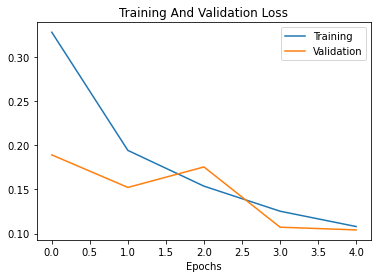

In [6]:
cnn.plot_train_result(cnn_hist)

In [8]:
cnn.save_weights('classification.h5')

In [13]:
#Realizando a validação do modelo em dados de teste
validation_train_eval = cnn.evaluate(images, labels, verbose=0)
print(f'Perda: {validation_train_eval[0]}\nAcurácia: {validation_train_eval[1]}')

Perda: 0.2385757714509964
Acurácia: 0.9375


In [15]:
#Realizando a validação do modelo noconjunto de validação
validation_eval = cnn.evaluate(val_images, val_labels, verbose=0)
print(f'Perda: {validation_eval[0]}\nAcurácia: {validation_eval[1]}')

Perda: 0.14927423000335693
Acurácia: 0.9375


## Testando o modelo

Para o teste final do modelo utilizamos os dados de maça do primeiro dataset(com 3200 imgs)

In [9]:
#Arquitetura do modelo que usaremos para o teste final
cnn.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  1456      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0       

In [10]:
#Realizando os mesmos processos de tratamento dos dados que utilizamos 
#para treinamento do modelo para realizar a avaliação final
test_path = 'data/test'
test_final_datagen = ImageDataGenerator(rescale=1/255)

test_final_data = test_final_datagen.flow_from_directory(directory=test_path,
                                              target_size=(224, 224),
                                              class_mode='binary',
                                              batch_size=32)



images, labels = test_final_data.next()
print(f'{len(images)}, {len(labels)}')

print(f'Tamanho do lote: {len(test_final_data)}')

Found 400 images belonging to 2 classes.
32, 32
Tamanho do lote: 13


In [11]:
#Realizando a validação do modelo com o conjunto de validação
test_eval = cnn.evaluate(images, labels, verbose=0)
print(f'Perda: {test_eval[0]}\nAcurácia: {test_eval[1]}')

Perda: 3.7442421913146973
Acurácia: 0.28125
